# Calibration Procedure

* Compute center offset:
 - Set $\lambda_{\rm center}$ to set of known spectral lines
 - Measure pixel position of each: 
 - average each to determine central pixel $n_o$
 
|   $\lambda_{\rm center}$ | Pixel |           
| ----------------------:  |:------:|
| 0   nm                   | 5.2 | 
| 445 nm                   | 6.22      |  
| 901 nm                   | 3.1      | 


 
* Compute spectrometer calibration angles/length ($\ f_L, \delta, \gamma$)
 * Move known spectral line $\lambda_o$ to left and right sides of detector
 * record $\lambda_{\rm center}$ and pixel position for each 
 * Compute best fit of $\ f_{\rm calib}$


| $\lambda_o$   | Side | $\lambda_{\rm center}$| Pixel  |
| ------------- | ---- |:----------------------|-------:|
| 809.4 nm      | R    |729.4910 nm            |508     |
| 809.4 nm      | L    |899.5830 nm            |  4     |
| ...           | ...  | ...                   |...     |



# Optimization Function

Optimize for 3 parameters:
 * $f_L$: Focal length of spectrometer
 * $\delta$: Detector angle (The angle of the image plane relative to the plane perpendicular to the spectrograph focal axis at the center of the image plane)
 * $\gamma$: inclusion angle

from experiment:
 * $n =  n_{px} - n_o$: Pixel from central pixel
 * $\lambda_{\rm center}$: Wavelength of center pixel 
 * $\lambda_p$: Wavelength of pixel $n$
 
Fixed Constants:
 * $m$: Diffraction order (typically one)
 * $x_{\rm pixel}$: pixel size
 * $d_{grating}$: Grating pitch (1/(groves / mm))
    
residual: (wl,  wl_p, n, f, delta,gamma)

We measure pixel position ($n$) of a known wavelength ($\lambda_p$) for multple peaks and spectrometer positions and find the best fit parameters $\ f_L, \delta, \gamma$:

$$ \lambda_p = f_{\rm calib} ( n,  \lambda_{\rm center}, 
    \underbrace{m, x_{\rm pixel}, d_{\rm grating}}_{\rm spec\ params}, 
    \overbrace{f_L,\ \ \delta,\ \ \gamma}^{\rm Calibration\ params} ) $$

$$ \lambda_p = \frac{d}{m} \cdot \left[ \sin( \psi - \frac{\gamma}{2}) + \sin(\psi+\frac{\gamma}{2} + \eta) \right]$$

Where

$$ \psi = \arcsin \left[ \frac{ m\ \lambda_{\rm center} } { 2\ d_{\rm grating} \cos(\frac{\gamma}{2})} \right] $$

$$ \eta = \arctan \left[ \frac{ n\ x_{pixel} \cos{\delta}} {f_L + n\ x_{pixel} \sin(\delta)} \right]$$

$$n =  n_{px} - n_o$$



In [12]:
from __future__ import division
import numpy as np
import  matplotlib.pyplot as plt
from pprint import pprint

%matplotlib notebook

In [46]:
def wl_p_calib(px, n0, wl_center, m_order, d_grating, x_pixel, f, delta, gamma):
    #consts
    #d_grating = 1./150. #mm
    #x_pixel   = 16e-3 # mm
    #m_order   = 1 # diffraction order, unitless
    n = px - n0

    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2.)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))
    
    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta)))

In [23]:
from scipy.optimize import least_squares

def fit_residual(
                # optimization parameters
                opt_params, 
                # other params and data
                px, n0, wl_center, m_order, d_grating, x_pixel,
                wl_actual
                ):
    
    (f, delta, gamma,) = opt_params
    wl_model = wl_p_calib(px, n0, wl_center, m_order, d_grating, x_pixel, f, delta, gamma)
    return wl_model - wl_actual

In [22]:
    
initial_guess = (300, 0, 0)

kwargs = dict(
    px=A, 
    n0=256,
    wl_center=A,
    m_order=1,
    d_grating=1/150.,
    x_pixel=16e-3,
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)

NameError: name 'A' is not defined

# CL calibration 

# grating 3 (150 g/mm Bz 500)

<IPython.core.display.Javascript object>


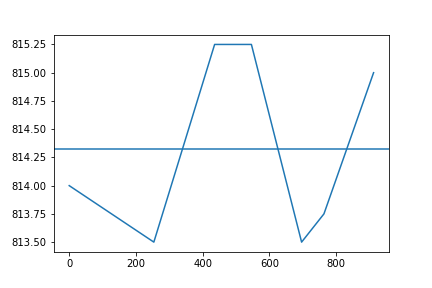

In [86]:
# grating 3 (150 g/mm Bz 500)

wl_center_data = np.array([
[0,     814],
[253.652, 813.5],
[435.833, 815.25],
[546.074, 815.25],
[696.543, 813.5],
[763.511, 813.75],
[912.297, 815.0],    
])
    
n0 = np.mean(wl_center_data[:,1])
n0    
plt.figure(1)
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [18]:
print(wl_center_data[:,0] - 250)
print(wl_center_data[:,0] + 250)


[-250.       3.652  185.833  296.074  446.543  513.511  662.297]
[  250.      503.652   685.833   796.074   946.543  1013.511  1162.297]


In [78]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[253.652, 503, 84],
[435.833, 685, 79],
[546.074, 796, 75],
[696.543, 946, 75.5],
[763.511, 1013, 73],
[912.297, 1162, 68],
[253.652, 3, 1546],
[435.833, 185, 1549],
[546.074, 296, 1548],
[696.543, 446, 1554.5],
[763.511, 513, 1556],
[912.297, 662, 1556],
[  0.000,   0,  814],
[253.652, 253.652, 813.5],
[435.833, 435.833, 815.25],
[546.074, 546.074, 815.25],
[696.543, 696.543, 813.5],
[763.511, 763.511, 813.75],
[912.297, 912.297, 815.0],    
])


In [80]:
initial_guess = (300,1,0)

kwargs = dict(
    px=dispersion_data[:,2], 
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1]*1e-6,
    m_order=1,
    d_grating=1/150.,
    x_pixel=16e-3,
    wl_actual=dispersion_data[:,0]*1e-6
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)
result.x

array([  3.00148820e+02,  -9.60897197e-02,   6.43713422e-01])

In [82]:
kwargs = dict(
    px=dispersion_data[:,2], 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1]*1e-6,
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/150.,
    x_pixel=16e-3,
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
)

wl_p_calib(**kwargs)*1e6 - dispersion_data[:,0]
#wl_p_calib(**kwargs)*1e6 - wl_center_data[:,0]

array([ 7.03640341,  6.47030494,  6.71430494,  7.53239443,  7.25775009,
        7.0096384 , -6.00353054, -6.46810215, -6.84605065, -6.30028407,
       -6.29277508, -7.25327843, -0.1078636 , -0.27375337,  0.30783893,
        0.30682777, -0.27017231, -0.18754849,  0.22164123])

In [41]:
wl_p_calib(px=815, n0=n0, wl_center=300e-6, m_order=1, d_grating=1/150., x_pixel=16e-3, f=300, delta=0, gamma=0)

0.0225018988701 0.0225


0.00030024120866372066

<IPython.core.display.Javascript object>


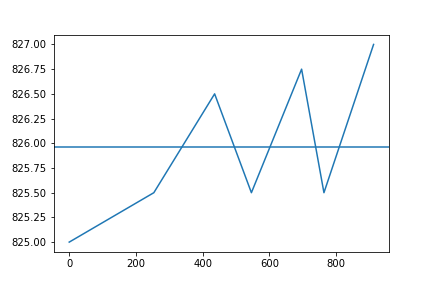

In [93]:
# grating 1 (300 g/mm Bz 500)

wl_center_data = np.array([
[0,     825],
[253.652, 825.5],
[435.833, 826.5],
[546.074, 825.5],
[696.543, 826.75],
[763.511, 825.5],
[912.297, 827.0],    
])
    
n0 = np.mean(wl_center_data[:,1])
n0    
plt.figure(2)
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [94]:
print(wl_center_data[:,0] - 120)
print(wl_center_data[:,0] + 130)

[-120.     133.652  315.833  426.074  576.543  643.511  792.297]
[  130.      383.652   565.833   676.074   826.543   893.511  1042.297]


In [95]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[253.652, 384, 55],
[435.833, 566, 49.5],
[546.074, 676, 47.5],
[696.543, 826, 41],
[763.511, 894, 34.5],
[912.297, 1042, 28.5],
[253.652, 134, 1526],
[435.833, 316, 1535],
[546.074, 426, 1542],
[696.543, 577, 1544.5],
[763.511, 644, 1547.5],
[912.297, 792, 1558.5],
[0, 0,    825],
[253.652, 253.652, 825.5],
[435.833, 435.833, 826.5],
[546.074, 546.074, 825.5],
[696.543, 696.543, 826.75],
[763.511, 763.511, 825.5],
[912.297, 912.297, 827.0],     
])


In [102]:
initial_guess = (300,1,0.1)

kwargs = dict(
    px=dispersion_data[:,2], 
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1]*1e-6,
    m_order=1,
    d_grating=1/300.,
    x_pixel=16e-3,
    wl_actual=dispersion_data[:,0]*1e-6
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)
result.x

array([  3.01083267e+02,   2.99979697e-02,   8.41107366e-01])

In [105]:
kwargs = dict(
    px=dispersion_data[:,2], 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1]*1e-6,
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/300.,
    x_pixel=16e-3,
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
)

wl_p_calib(**kwargs)*1e6 - dispersion_data[:,0]
#wl_p_calib(**kwargs)*1e6 - wl_center_data[:,0]

array([  8.15324359,   8.98998331,   9.63939298,   9.88084466,
        10.72584205,  10.86627328,  -8.83242142,  -9.32488945,
        -9.58828622, -10.2534592 , -10.49710513, -11.324143  ,
        -0.15585964,  -0.07357901,   0.08359121,  -0.0717289 ,
         0.11965824,  -0.07023959,   0.15428468])

# Old Version 

In [ ]:
from lmfit import Parameters, minimize

In [2]:
offset_data = np.array([
[0,     5.1940],
[435.8, 441.0860],
[546.1, 551.3630],
[610.8, 616.2860],
[809.4, 814.4940],
])

In [ ]:
offset_

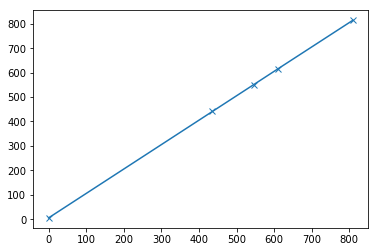

In [3]:
pl.plot(offset_data[:,0], offset_data[:,1], 'x-')

In [5]:
wl_offset = np.average(offset_data[:,0]-offset_data[:,1])
print(wl_offset, "nm")

-5.2646 nm



Dispersion

809.4, R, 508, 729.4910

809.4, L, 004, 899.5830

610.8, R, 508, 531.0920

610.8, L, 004, 701.9610


435.8, R, 508, 354.9880

435.8, L, 004, 526.9880


In [6]:
D = dispersion_data = np.array([
[809.4, 508, 729.4910],
[809.4, 4, 899.5830],
[610.8, 508, 531.0920],
[610.8, 4, 701.9610],
[435.8, 508, 354.9880],
[435.8, 4, 526.9880]
])
data  = dict(
    wl = 1e-6*(D[:,2] + wl_offset),
    n  = D[:,1] - 256,
    wl_p = 1e-6*D[:,0],
)

data

{'n': array([ 252., -252.,  252., -252.,  252., -252.]),
 'wl': array([ 0.00072423,  0.00089432,  0.00052583,  0.0006967 ,  0.00034972,
         0.00052172]),
 'wl_p': array([ 0.0008094,  0.0008094,  0.0006108,  0.0006108,  0.0004358,
         0.0004358])}

In [86]:

def wl_p_func(wl_center, n, f, delta, gamma):
    #consts
    d_grating = 1./150. #mm
    x_pixel   = 16e-3 # mm
    m_order   = 1 # diffraction order, unitless

    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))

    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta)))

def residual(wl_center, wl_p, n, f, delta, gamma):

    #print 'wl_center', wl_center.shape
    #print 'psi', psi.shape
    #print 'eta', eta.shape
    
    residual = -wl_p + wl_p_func(wl_center, n, f, delta, gamma)
    return residual


In [90]:
def residual_lmfit(params, x, data):
    f = params['f'].value
    delta = params['delta'].value
    gamma = params['gamma'].value
    
    wl = data['wl']
    wl_p = data['wl_p']
    n = data['n']
    
    return residual(wl, wl_p, n, f, delta, gamma)


params = Parameters()
params.add('f', value=300, vary=True)#, min=280, max=320, vary=True)
params.add('delta', value=0)#, min=-np.pi/8, max=np.pi/8, vary=True)
params.add('gamma', value=np.pi/6)#, min=0, max=np.pi/4, vary=True)


result = minimize(residual_lmfit, params, args=(0,data,))

print result.success, result.message
pprint(params.values())

True Tolerance seems to be too small.
[<Parameter 'f', value=293.49670609146182 +/- 13.6, bounds=[-inf:inf]>,
 <Parameter 'delta', value=0.070372962086993743 +/- 0.134, bounds=[-inf:inf]>,
 <Parameter 'gamma', value=0.62226390460467274 +/- 0.239, bounds=[-inf:inf]>]


In [48]:
180*0.0233/np.pi

1.3349916626548182

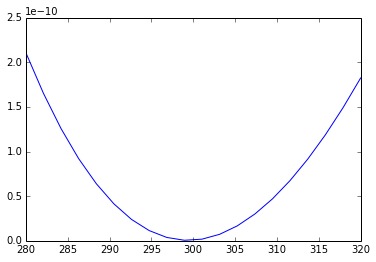

In [79]:
f_array = np.linspace(280,320, 20)
delta = 0
gamma = np.pi/6.
pl.plot(f_array, 
            [np.sum((residual(data['wl'], data['wl_p'], data['n'], 
                              f, delta, gamma))**2)
             for f in f_array])

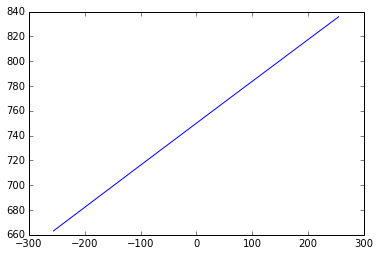

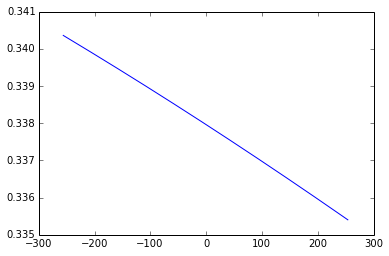

In [76]:
f = params['f'].value
delta = params['delta'].value
gamma = params['gamma'].value

pixels = np.arange(-256,256)
#print wl_p_func(750e-6, pixels, f, delta, gamma)*1e6

pl.plot( pixels, wl_p_func((750e-6, pixels, f, delta, gamma)*1e6)
pl.figure()
pl.plot( pixels[:-1], np.diff(wl_p_func(750e-6, pixels, f, delta, gamma)*1e6))

